<a href="https://colab.research.google.com/github/samanmoshiri/eurusd-forecasting/blob/main/eurusd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
register_matplotlib_converters()
from time import time
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

# Data Preproccesing



In [101]:
column_names= ['date','hour','open','high','low','close','volume']
lines = pd.read_csv('eurusd-15m.csv',delimiter=';',names=column_names)

print(lines)

              date      hour     open     high      low    close  volume
0       21/10/2002  01:15:00  0.97320  0.97340  0.97260  0.97260       0
1       21/10/2002  01:30:00  0.97260  0.97275  0.97195  0.97205       0
2       21/10/2002  01:45:00  0.97215  0.97235  0.97195  0.97210       0
3       21/10/2002  02:00:00  0.97200  0.97260  0.97190  0.97240       0
4       21/10/2002  02:15:00  0.97235  0.97250  0.97220  0.97225       0
...            ...       ...      ...      ...      ...      ...     ...
533057  26/10/2023  18:30:00  1.05640  1.05656  1.05636  1.05638    1426
533058  26/10/2023  18:45:00  1.05639  1.05655  1.05627  1.05640    1114
533059  26/10/2023  19:00:00  1.05640  1.05644  1.05575  1.05575    1804
533060  26/10/2023  19:15:00  1.05575  1.05612  1.05575  1.05598    1488
533061  26/10/2023  19:30:00  1.05597  1.05618  1.05593  1.05594    1571

[533062 rows x 7 columns]


In [102]:
lines['Time'] = lines['date'].astype(str) +' '+ lines['hour'].astype(str)
lines.set_index('Time', inplace=True)
lines

,date,hour,open,high,low,close,volume
Time,,,,,,,
21/10/2002 01:15:00,21/10/2002,01:15:00,0.97320,0.97340,0.97260,0.97260,0
21/10/2002 01:30:00,21/10/2002,01:30:00,0.97260,0.97275,0.97195,0.97205,0
21/10/2002 01:45:00,21/10/2002,01:45:00,0.97215,0.97235,0.97195,0.97210,0
21/10/2002 02:00:00,21/10/2002,02:00:00,0.97200,0.97260,0.97190,0.97240,0
21/10/2002 02:15:00,21/10/2002,02:15:00,0.97235,0.97250,0.97220,0.97225,0
...,...,...,...,...,...,...,...
26/10/2023 18:30:00,26/10/2023,18:30:00,1.05640,1.05656,1.05636,1.05638,1426
26/10/2023 18:45:00,26/10/2023,18:45:00,1.05639,1.05655,1.05627,1.05640,1114
26/10/2023 19:00:00,26/10/2023,19:00:00,1.05640,1.05644,1.05575,1.05575,1804


In [107]:
df = pd.DataFrame(lines)
df = df.drop(['date','hour','volume'],axis=1)
df = df.iloc[487218: , : ]
last = df.iloc[-1]
df = df.iloc[:-1]

In [108]:
any_nan_values = df.isna().any().any()
any_nan_values

False

In [109]:
last

open     1.05597
high     1.05618
low      1.05593
close    1.05594
Name: 26/10/2023 19:30:00, dtype: float64

In [110]:
df

,open,high,low,close
Time,,,,
02/01/2022 15:00:00,1.13674,1.13674,1.13664,1.13664
02/01/2022 15:15:00,1.13658,1.13658,1.13656,1.13656
02/01/2022 15:30:00,1.13658,1.13662,1.13655,1.13655
02/01/2022 15:45:00,1.13656,1.13656,1.13653,1.13654
02/01/2022 16:00:00,1.13655,1.13685,1.13651,1.13683
...,...,...,...,...
26/10/2023 18:15:00,1.05643,1.05646,1.05638,1.05640
26/10/2023 18:30:00,1.05640,1.05656,1.05636,1.05638
26/10/2023 18:45:00,1.05639,1.05655,1.05627,1.05640


# Scaling

In [111]:
scaler = StandardScaler()
scaler = scaler.fit(df)
df_scaled = pd.DataFrame()
df_scaled = scaler.transform(df)
df_scaled = pd.DataFrame(df_scaled)
df_scaled

,0,1,2,3
0,1.727546,1.720604,1.732202,1.725223
1,1.723645,1.716697,1.730254,1.723272
2,1.723645,1.717674,1.730011,1.723028
3,1.723157,1.716209,1.729524,1.722784
4,1.722914,1.723290,1.729037,1.729856
...,...,...,...,...
45838,-0.230720,-0.239809,-0.222091,-0.231403
45839,-0.231451,-0.237367,-0.222578,-0.231891
45840,-0.231695,-0.237611,-0.224770,-0.231403
45841,-0.231451,-0.240297,-0.237431,-0.247253


Text(0, 0.5, 'Sales')

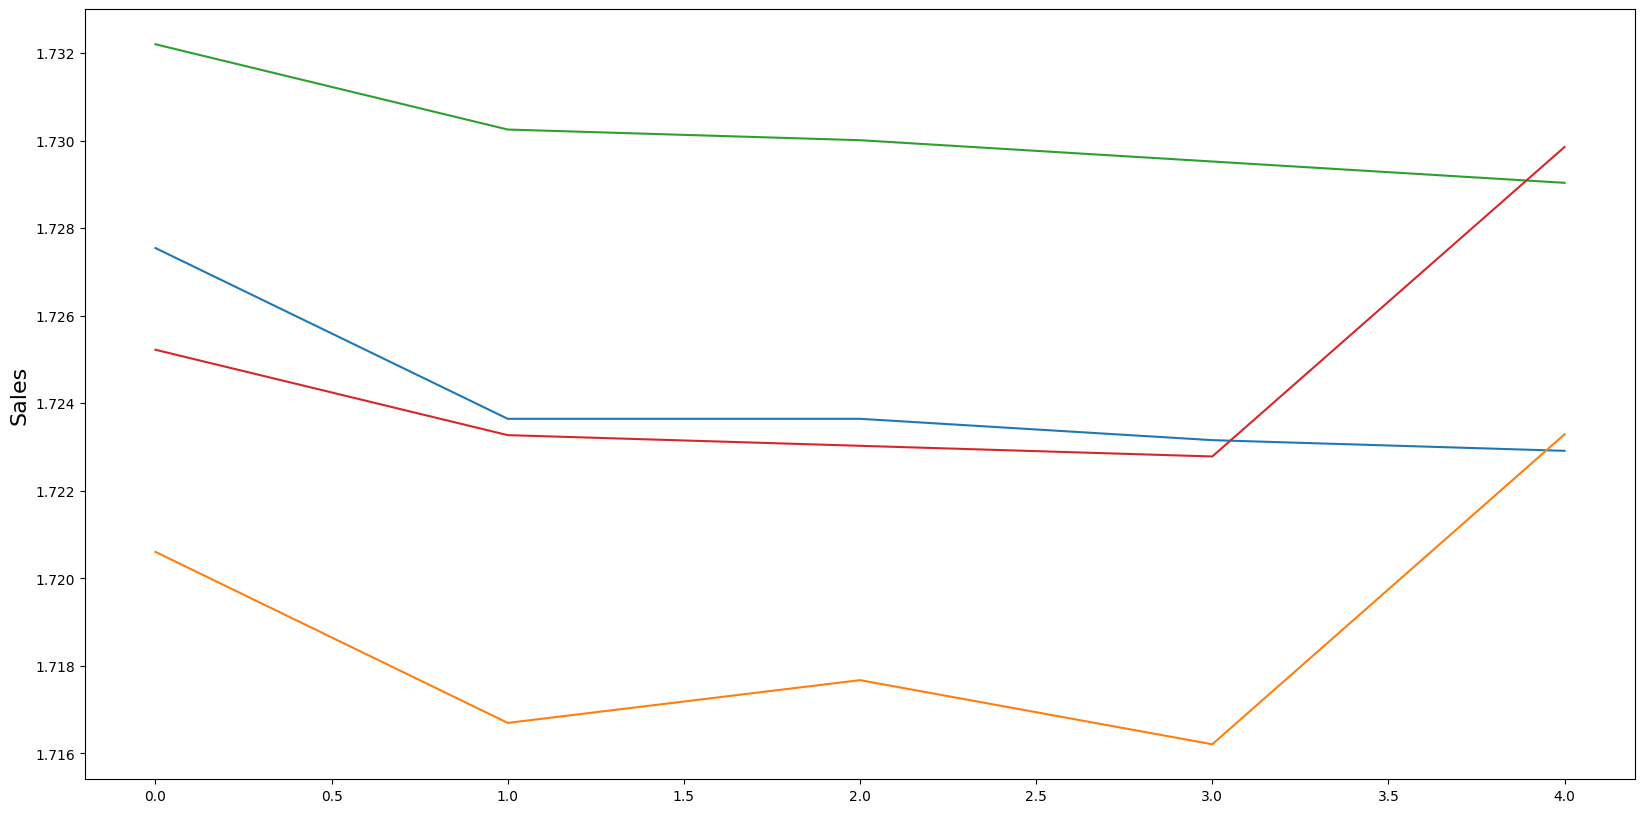

In [112]:
plt.figure(figsize=(20,10))
plt.plot(df_scaled.head())
#plt.title('Log of HSI', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [113]:
df.head()

,open,high,low,close
Time,,,,
02/01/2022 15:00:00,1.13674,1.13674,1.13664,1.13664
02/01/2022 15:15:00,1.13658,1.13658,1.13656,1.13656
02/01/2022 15:30:00,1.13658,1.13662,1.13655,1.13655
02/01/2022 15:45:00,1.13656,1.13656,1.13653,1.13654
02/01/2022 16:00:00,1.13655,1.13685,1.13651,1.13683


In [114]:
trainX = []
trainY = []

n_future = 1
n_past = 15

for i in range(n_past, len(df_scaled) - n_future + 1):
    trainX.append(df_scaled.iloc[i - n_past:i, 0:df_scaled.shape[1]].values)
    trainY.append(df_scaled.iloc[i + n_future - 1:i + n_future, 0].values)

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (45828, 15, 4).
trainY shape == (45828, 1).


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 15, 64)            17664     
                                                                 
 lstm_23 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 4)                 132       
                                                                 
Total params: 30212 (118.02 KB)
Trainable params: 30212 (118.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
2578/2578 [==============================] - 48s 17ms/step - loss: 0.0546 - val_loss: 9.7226e-04
Epoch 2/10
2578/2578 [=================

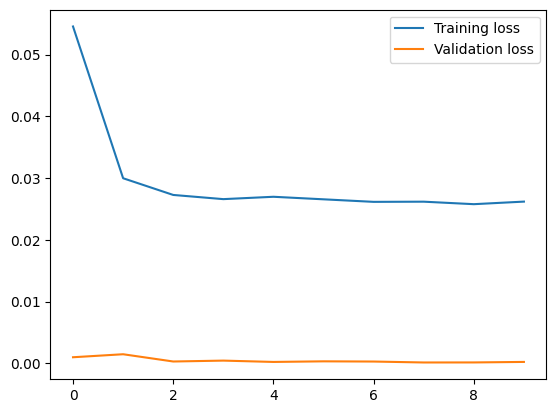

In [120]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(4))

model.compile(optimizer='adam', loss='mse')
model.summary()


# fit the model
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [121]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

#predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
#print(predict_period_dates)

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
#prediction_copies = np.repeat(prediction, df.shape[1], axis=-1)
#y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
prediction_copies = np.repeat(prediction[:, np.newaxis, :], df.shape[1], axis=-1)

# Reshape the prediction_copies to align with df.shape
prediction_copies_reshaped = prediction_copies.reshape(-1, df.shape[1])

y_pred_future = scaler.inverse_transform(prediction_copies_reshaped)[:, 0]

# Convert timestamp to daty
y_pred_future

1/1 [==============================] - 0s 293ms/step


array([1.0563436, 1.0563436, 1.0563436, 1.0563436, 1.0564718, 1.0564718,
       1.0564718, 1.0564718, 1.056511 , 1.056511 , 1.056511 , 1.056511 ,
       1.056511 , 1.056511 , 1.056511 , 1.056511 , 1.0565598, 1.0565598,
       1.0565598, 1.0565598, 1.056578 , 1.056578 , 1.056578 , 1.056578 ,
       1.056661 , 1.0566609, 1.056661 , 1.056661 , 1.056735 , 1.056735 ,
       1.056735 , 1.056735 , 1.056793 , 1.056793 , 1.056793 , 1.056793 ,
       1.0568504, 1.0568504, 1.0568504, 1.0568504, 1.0568779, 1.0568779,
       1.0568779, 1.0568779, 1.0568807, 1.0568807, 1.0568807, 1.0568807,
       1.0568851, 1.0568851, 1.0568851, 1.0568851, 1.0568787, 1.0568787,
       1.0568787, 1.0568787, 1.0567343, 1.0567343, 1.0567343, 1.0567343],
      dtype=float32)

In [45]:
trainX

array([[[-2.0196251 , -2.02006704, -2.02240581, -2.02427071],
        [-2.02428311, -2.02510828, -2.02745792, -2.02854046],
        [-2.02777662, -2.02821059, -2.02745792, -2.0281523 ],
        ...,
        [-2.00487473, -2.00494331, -2.00452913, -2.00331013],
        [-2.00371023, -2.00339215, -2.00219739, -2.00408645],
        [-2.00371023, -2.00067764, -2.00180877, -1.99904039]],

       [[-2.02428311, -2.02510828, -2.02745792, -2.02854046],
        [-2.02777662, -2.02821059, -2.02745792, -2.0281523 ],
        [-2.02894112, -2.02627165, -2.02784654, -2.02582335],
        ...,
        [-2.00371023, -2.00339215, -2.00219739, -2.00408645],
        [-2.00371023, -2.00067764, -2.00180877, -1.99904039],
        [-1.99866405, -1.99718755, -1.99869978, -1.9998167 ]],

       [[-2.02777662, -2.02821059, -2.02745792, -2.0281523 ],
        [-2.02894112, -2.02627165, -2.02784654, -2.02582335],
        [-2.02622395, -2.02704722, -2.0255148 , -2.02698782],
        ...,
        [-2.00371023, -2.00

# *HIGH*

In [46]:
df = df[['high','low','close','open']]
df

,high,low,close,open
Time,,,,
21/10/2002 01:15:00,0.97340,0.97260,0.97260,0.97320
21/10/2002 01:30:00,0.97275,0.97195,0.97205,0.97260
21/10/2002 01:45:00,0.97235,0.97195,0.97210,0.97215
21/10/2002 02:00:00,0.97260,0.97190,0.97240,0.97200
21/10/2002 02:15:00,0.97250,0.97220,0.97225,0.97235
...,...,...,...,...
26/10/2023 18:00:00,1.05658,1.05631,1.05643,1.05646
26/10/2023 18:15:00,1.05646,1.05638,1.05640,1.05643
26/10/2023 18:30:00,1.05656,1.05636,1.05638,1.05640


In [47]:
scaler = StandardScaler()
scaler = scaler.fit(df)
df_scaled = pd.DataFrame()
df_scaled = scaler.transform(df)
df_scaled = pd.DataFrame(df_scaled)
df_scaled

,0,1,2,3
0,-2.020067,-2.022406,-2.024271,-2.019625
1,-2.025108,-2.027458,-2.028540,-2.024283
2,-2.028211,-2.027458,-2.028152,-2.027777
3,-2.026272,-2.027847,-2.025823,-2.028941
4,-2.027047,-2.025515,-2.026988,-2.026224
...,...,...,...,...
533055,-1.374943,-1.371772,-1.373484,-1.373249
533056,-1.375874,-1.371228,-1.373716,-1.373482
533057,-1.375098,-1.371384,-1.373872,-1.373714
533058,-1.375176,-1.372083,-1.373716,-1.373792


In [48]:
trainX = []
trainY = []

n_future = 1
n_past = 15

for i in range(n_past, len(df_scaled) - n_future + 1):
    trainX.append(df_scaled.iloc[i - n_past:i, 0:df_scaled.shape[1]].values)
    trainY.append(df_scaled.iloc[i + n_future - 1:i + n_future, 0].values)

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (533045, 15, 4).
trainY shape == (533045, 1).


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 15, 64)            17664     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30113 (117.63 KB)
Trainable params: 30113 (117.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
29984/29984 [==============================] - 493s 16ms/step - loss: 0.0227 - val_loss: 0.0085
Epoch 2/5
29984/29984 [===================

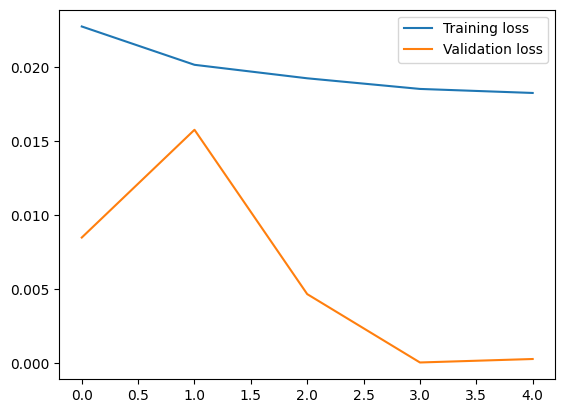

In [49]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [50]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

#predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
#print(predict_period_dates)

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]



# Convert timestamp to daty
y_pred_future

1/1 [==============================] - 0s 289ms/step


array([1.0590054, 1.0586866, 1.0591598, 1.0587279, 1.0589032, 1.059096 ,
       1.0588541, 1.0593497, 1.0590878, 1.0592998, 1.0593034, 1.0592428,
       1.0592418, 1.0592767, 1.0591992], dtype=float32)

In [51]:
trainX

array([[[-2.02006704, -2.02240581, -2.02427071, -2.0196251 ],
        [-2.02510828, -2.02745792, -2.02854046, -2.02428311],
        [-2.02821059, -2.02745792, -2.0281523 , -2.02777662],
        ...,
        [-2.00494331, -2.00452913, -2.00331013, -2.00487473],
        [-2.00339215, -2.00219739, -2.00408645, -2.00371023],
        [-2.00067764, -2.00180877, -1.99904039, -2.00371023]],

       [[-2.02510828, -2.02745792, -2.02854046, -2.02428311],
        [-2.02821059, -2.02745792, -2.0281523 , -2.02777662],
        [-2.02627165, -2.02784654, -2.02582335, -2.02894112],
        ...,
        [-2.00339215, -2.00219739, -2.00408645, -2.00371023],
        [-2.00067764, -2.00180877, -1.99904039, -2.00371023],
        [-1.99718755, -1.99869978, -1.9998167 , -1.99866405]],

       [[-2.02821059, -2.02745792, -2.0281523 , -2.02777662],
        [-2.02627165, -2.02784654, -2.02582335, -2.02894112],
        [-2.02704722, -2.0255148 , -2.02698782, -2.02622395],
        ...,
        [-2.00067764, -2.00

# *LOW*

In [52]:
df = df[['low','close','open','high']]
df

,low,close,open,high
Time,,,,
21/10/2002 01:15:00,0.97260,0.97260,0.97320,0.97340
21/10/2002 01:30:00,0.97195,0.97205,0.97260,0.97275
21/10/2002 01:45:00,0.97195,0.97210,0.97215,0.97235
21/10/2002 02:00:00,0.97190,0.97240,0.97200,0.97260
21/10/2002 02:15:00,0.97220,0.97225,0.97235,0.97250
...,...,...,...,...
26/10/2023 18:00:00,1.05631,1.05643,1.05646,1.05658
26/10/2023 18:15:00,1.05638,1.05640,1.05643,1.05646
26/10/2023 18:30:00,1.05636,1.05638,1.05640,1.05656


In [53]:
scaler = StandardScaler()
scaler = scaler.fit(df)
df_scaled = pd.DataFrame()
df_scaled = scaler.transform(df)
df_scaled = pd.DataFrame(df_scaled)
df_scaled

,0,1,2,3
0,-2.022406,-2.024271,-2.019625,-2.020067
1,-2.027458,-2.028540,-2.024283,-2.025108
2,-2.027458,-2.028152,-2.027777,-2.028211
3,-2.027847,-2.025823,-2.028941,-2.026272
4,-2.025515,-2.026988,-2.026224,-2.027047
...,...,...,...,...
533055,-1.371772,-1.373484,-1.373249,-1.374943
533056,-1.371228,-1.373716,-1.373482,-1.375874
533057,-1.371384,-1.373872,-1.373714,-1.375098
533058,-1.372083,-1.373716,-1.373792,-1.375176


In [54]:
trainX = []
trainY = []

n_future = 1
n_past = 15

for i in range(n_past, len(df_scaled) - n_future + 1):
    trainX.append(df_scaled.iloc[i - n_past:i, 0:df_scaled.shape[1]].values)
    trainY.append(df_scaled.iloc[i + n_future - 1:i + n_future, 0].values)

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (533045, 15, 4).
trainY shape == (533045, 1).


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 15, 64)            17664     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30113 (117.63 KB)
Trainable params: 30113 (117.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
29984/29984 [==============================] - 513s 17ms/step - loss: 0.0235 - val_loss: 0.0024
Epoch 2/5
29984/29984 [===================

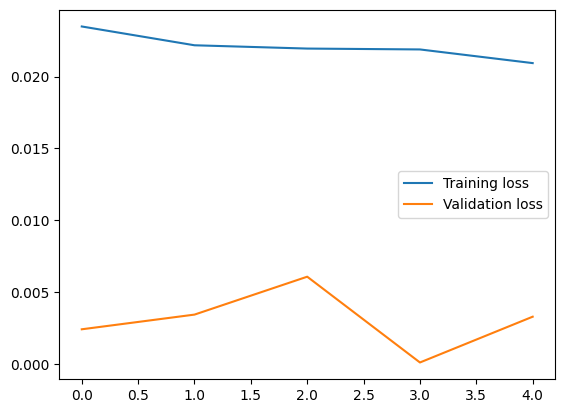

In [55]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [56]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

#predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
#print(predict_period_dates)

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]



# Convert timestamp to daty
y_pred_future

1/1 [==============================] - 0s 421ms/step


array([1.0634317, 1.0633342, 1.0635916, 1.0634187, 1.0634712, 1.0636715,
       1.0634717, 1.0638535, 1.0636798, 1.0638496, 1.063863 , 1.0638375,
       1.0638599, 1.0638713, 1.0638374], dtype=float32)

In [57]:
trainX

array([[[-2.02240581, -2.02427071, -2.0196251 , -2.02006704],
        [-2.02745792, -2.02854046, -2.02428311, -2.02510828],
        [-2.02745792, -2.0281523 , -2.02777662, -2.02821059],
        ...,
        [-2.00452913, -2.00331013, -2.00487473, -2.00494331],
        [-2.00219739, -2.00408645, -2.00371023, -2.00339215],
        [-2.00180877, -1.99904039, -2.00371023, -2.00067764]],

       [[-2.02745792, -2.02854046, -2.02428311, -2.02510828],
        [-2.02745792, -2.0281523 , -2.02777662, -2.02821059],
        [-2.02784654, -2.02582335, -2.02894112, -2.02627165],
        ...,
        [-2.00219739, -2.00408645, -2.00371023, -2.00339215],
        [-2.00180877, -1.99904039, -2.00371023, -2.00067764],
        [-1.99869978, -1.9998167 , -1.99866405, -1.99718755]],

       [[-2.02745792, -2.0281523 , -2.02777662, -2.02821059],
        [-2.02784654, -2.02582335, -2.02894112, -2.02627165],
        [-2.0255148 , -2.02698782, -2.02622395, -2.02704722],
        ...,
        [-2.00180877, -1.99

# *close*

In [58]:
df = df[['close','open','high','low']]
df

,close,open,high,low
Time,,,,
21/10/2002 01:15:00,0.97260,0.97320,0.97340,0.97260
21/10/2002 01:30:00,0.97205,0.97260,0.97275,0.97195
21/10/2002 01:45:00,0.97210,0.97215,0.97235,0.97195
21/10/2002 02:00:00,0.97240,0.97200,0.97260,0.97190
21/10/2002 02:15:00,0.97225,0.97235,0.97250,0.97220
...,...,...,...,...
26/10/2023 18:00:00,1.05643,1.05646,1.05658,1.05631
26/10/2023 18:15:00,1.05640,1.05643,1.05646,1.05638
26/10/2023 18:30:00,1.05638,1.05640,1.05656,1.05636


In [59]:
scaler = StandardScaler()
scaler = scaler.fit(df)
df_scaled = pd.DataFrame()
df_scaled = scaler.transform(df)
df_scaled = pd.DataFrame(df_scaled)
df_scaled

,0,1,2,3
0,-2.024271,-2.019625,-2.020067,-2.022406
1,-2.028540,-2.024283,-2.025108,-2.027458
2,-2.028152,-2.027777,-2.028211,-2.027458
3,-2.025823,-2.028941,-2.026272,-2.027847
4,-2.026988,-2.026224,-2.027047,-2.025515
...,...,...,...,...
533055,-1.373484,-1.373249,-1.374943,-1.371772
533056,-1.373716,-1.373482,-1.375874,-1.371228
533057,-1.373872,-1.373714,-1.375098,-1.371384
533058,-1.373716,-1.373792,-1.375176,-1.372083


In [60]:
trainX = []
trainY = []

n_future = 1
n_past = 15

for i in range(n_past, len(df_scaled) - n_future + 1):
    trainX.append(df_scaled.iloc[i - n_past:i, 0:df_scaled.shape[1]].values)
    trainY.append(df_scaled.iloc[i + n_future - 1:i + n_future, 0].values)

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (533045, 15, 4).
trainY shape == (533045, 1).


In [61]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 15, 64)            17664     
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30113 (117.63 KB)
Trainable params: 30113 (117.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
29984/29984 [==============================] - 496s 16ms/step - loss: 0.0208 - val_loss: 8.6624e-04
Epoch 2/5
29984/29984 [===============

KeyboardInterrupt: ignored

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

#predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
#print(predict_period_dates)

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]



# Convert timestamp to daty
y_pred_future

In [ ]:
trainX